Iteration: 0, Loss: 511721760.0000
Iteration: 100, Loss: 12191503.0000
Iteration: 200, Loss: 4054584.7500
Iteration: 300, Loss: 2024750.3750
Iteration: 400, Loss: 1362622.2500
Iteration: 500, Loss: 1056755.2500
Iteration: 600, Loss: 889881.4375
Iteration: 700, Loss: 786849.2500
Iteration: 800, Loss: 717365.2500
Iteration: 900, Loss: 667707.8750


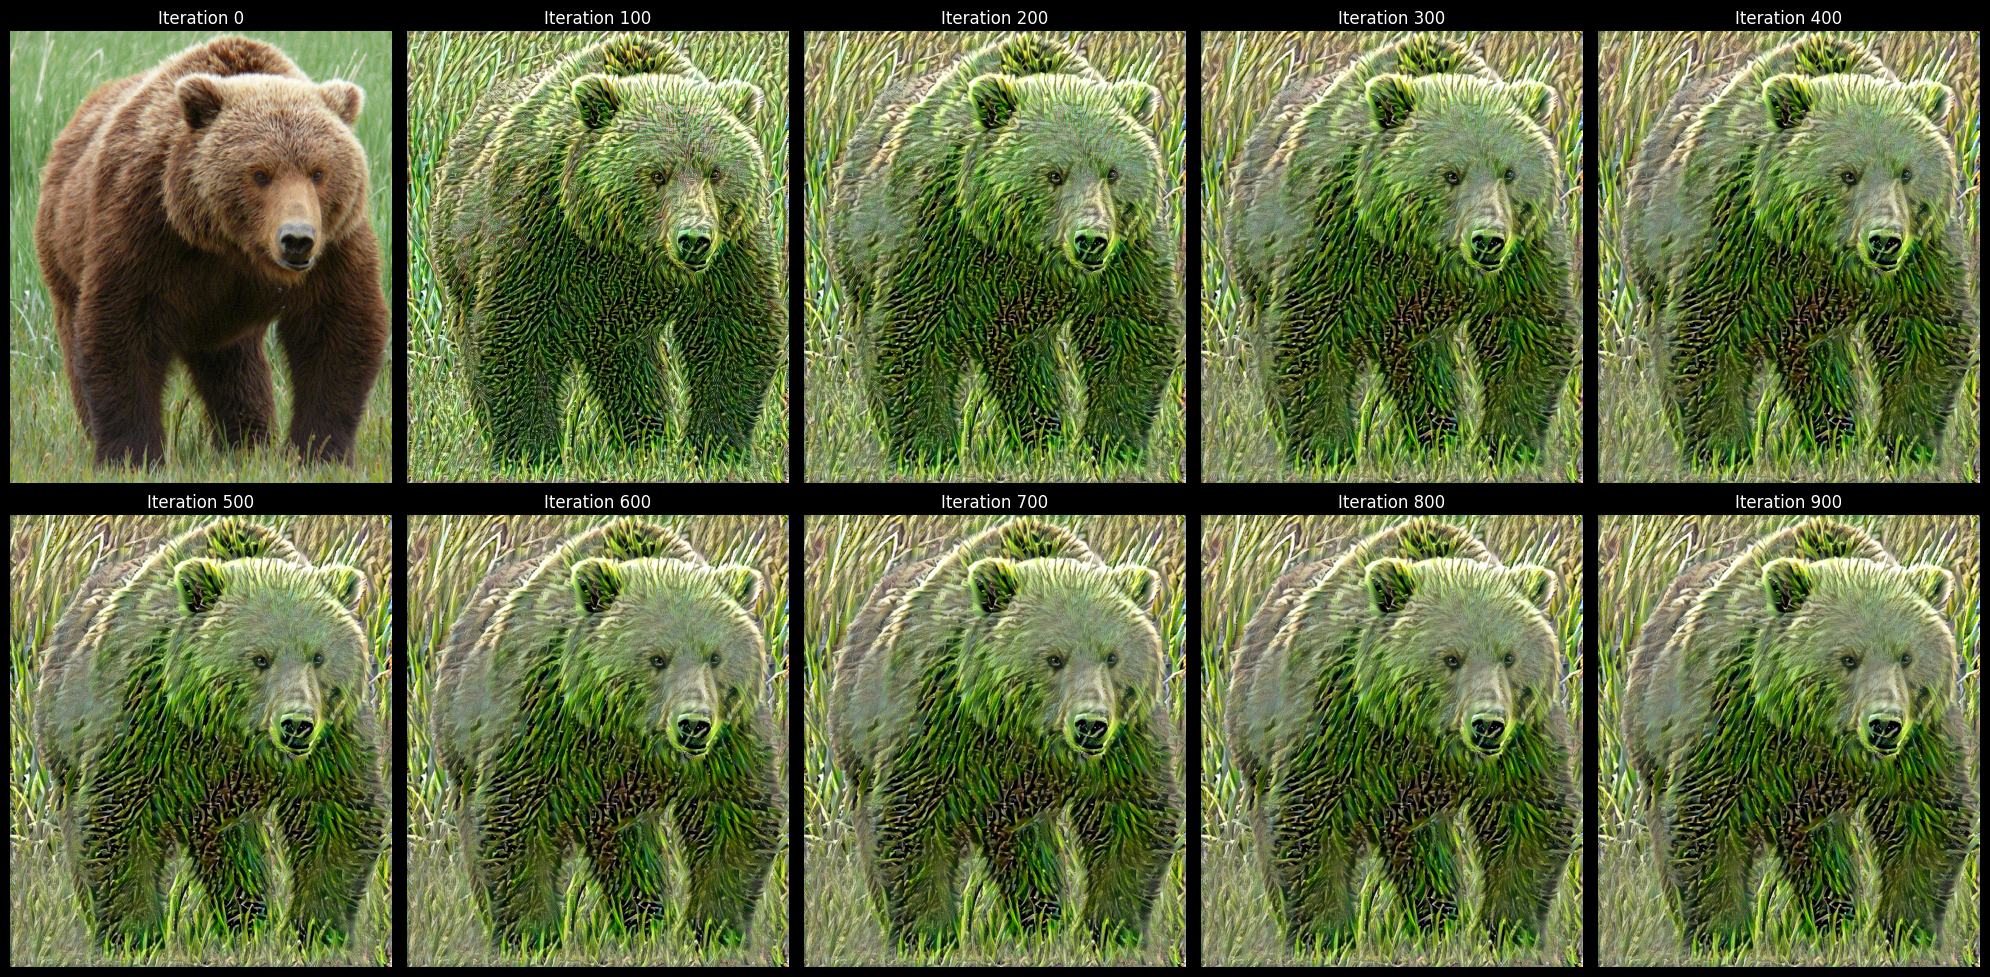

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
def load_and_process_img(path_to_img):
    max_dim = 512
    img = load_img(path_to_img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Deprocess images
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Total variation loss
def total_variation_loss(img):
    x_deltas, y_deltas = img[:, 1:, :, :] - img[:, :-1, :, :], img[:, :, 1:, :] - img[:, :, :-1, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# Compute loss and gradients
@tf.function
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight, tv_weight = loss_weights
    
    with tf.GradientTape() as tape:
        outputs = model(init_image)
        style_output_features = outputs['style']
        content_output_features = outputs['content']
        
        style_loss = 0
        content_loss = 0
        
        for style_feature, gram_style in zip(style_output_features, gram_style_features):
            style_loss += get_style_loss(style_feature[0], gram_style)
        
        for content_feature, target_content in zip(content_output_features, content_features):
            content_loss += get_content_loss(content_feature[0], target_content)
        
        style_loss *= style_weight / len(style_output_features)
        content_loss *= content_weight / len(content_output_features)
        
        tv_loss = tv_weight * total_variation_loss(init_image)
        
        total_loss = style_loss + content_loss + tv_loss
    
    grad = tape.gradient(total_loss, init_image)
    return total_loss, grad

# Perform style transfer
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    content_layers = ['block5_conv2'] 
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    
    model = tf.keras.Model(inputs=vgg.input, outputs={
        'content': [vgg.get_layer(name).output for name in content_layers],
        'style': [vgg.get_layer(name).output for name in style_layers]
    })
    
    content_targets = model(content_image)['content']
    style_targets = model(style_image)['style']
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_targets]
    
    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)
    
    loss_weights = (style_weight, content_weight, 1e-3)
    
    images = []
    for i in range(num_iterations):
        loss, grad = compute_loss(model, loss_weights, init_image, gram_style_features, content_targets)
        opt.apply_gradients([(grad, init_image)])
        if i % 100 == 0:
            images.append(deprocess_img(init_image.numpy()))
            print(f'Iteration: {i}, Loss: {loss.numpy():.4f}')
    
    return images

# Main execution
content_path = '/home/alibina/repo/ml_learning/fastai/course22p2/nbs/images/grizzly.jpg'
style_path = '/home/alibina/repo/ml_learning/fastai/course22/paddy-disease-classification/train_images/bacterial_panicle_blight/100254.jpg'
result_images = run_style_transfer(content_path, style_path)

# Plot results
plt.figure(figsize=(20, 10))
for i, img in enumerate(result_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Iteration {i*100}')
    plt.axis('off')
plt.tight_layout()
plt.show()